[기초부터 시작하는 NLP: 문자-단위 RNN으로 이름 분류하기](https://tutorials.pytorch.kr/intermediate/char_rnn_classification_tutorial.html)

## 문자 단위 RNN이름 분류

__단어를 분류하기 위해 기초적인 문자 단위 RNN 학습__\
NLP 모델링을 통해 torchtext의 편리한 기능을 사용하지 않고 데이터를 처리하는 방법 익힘\
단어를 문자의 연속으로 읽어서 각 단계의 예측과 은닉 상태 출력, 다음 단계에 이전 단계의 은닉 상태 전달\
단어가 속한 클래스로 출력되도록 최종 예측 선택

예) 철자에 따라 이름이 어떤 언어인지 예측하기
```bash
$ python predict.py Hinton
(-0.47) Scottish
(-1.52) English
(-3.57) Irish

$ python predict.py Schmidhuber
(-0.19) German
(-2.48) Czech
(-2.68) Dutch
```

## 데이터 준비

[데이터 다운로드](https://download.pytorch.org/tutorial/data.zip)

`data/names`디렉토리에는 18개의 텍스트 파일이 존재

각 언어 별로 이름 목록 사전을 만들기

In [34]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# 유니코드 문자열을 ASCII코드로 변환하기
def unicodeToAscii(s):
    return ''.join(
        # normalize: 'NFD' form으로 정규화하기, 발음구별 기호와 알파벳으로 분리
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn' # c가 발음 기호인지 체크
        and c in all_letters # c가 알파멧인지 다시 확인
    )

print(unicodeToAscii('Ślusàrski'))

# 각 언어의 이름 목록 사전 생성
category_lines = {}
all_categories = []

# 파일을 읽은 뒤 줄 단위로 분리
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    # os.path.splitext:
        # [0]: 나머지 부분
        # [1]: 파일의 확장자
    # os.path.basename: 파일 이름만 반환
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Arabic.txt', 'data/names/Dutch.txt', 'data/names/Polish.txt', 'data/names/Greek.txt', 'data/names/Russian.txt', 'data/names/Japanese.txt', 'data/names/Czech.txt', 'data/names/Korean.txt', 'data/names/Italian.txt', 'data/names/English.txt', 'data/names/Chinese.txt', 'data/names/Portuguese.txt', 'data/names/German.txt', 'data/names/Spanish.txt', 'data/names/Scottish.txt', 'data/names/Irish.txt', 'data/names/French.txt', 'data/names/Vietnamese.txt']
Slusarski


In [35]:
# all_categories와 n_categories도 추적하기
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


## 이름을 Tensor로 변경

In [36]:
"""
이름을 활용하기 위해 Tensor로 변환해야 한다
하나의 문자 표현을 위해 <1 * n_letters> 크기인 one-hot 벡터 사용하기
하나의 단어 표현을 위해 <line_length * 1 * n_letters> 2차원 행렬에 one-hot 벡터들을 결합시키기
"""

import torch

# all_letters로 문자 주소 찾기 (예) "a"=0
def letterToIndex(letter):
    return all_letters.find(letter)

# 검증을 위해 한 개의 문자를 <1 * n_letters> 텐서로 변환
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# 이름을 <line_length * 1 * n_letter>로 변경
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


## 네트워크 생성

![](https://i.imgur.com/Z2xbySO.png)

In [37]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [38]:
"""
네트워크의 한 단계 실행을 위해 입력 및 이전의 은닉 상태(처음에는 0으로 초기화)를 전달

출력(각 언어의 확률)과 다음 은닉 상태를 돌려받는다
"""

input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input, hidden)

In [39]:
# 효율성을 위해 letterToTensor 대신 lineToTensor 사용
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8298, -2.8065, -2.9311, -2.8896, -2.8728, -2.9275, -3.0028, -2.9075,
         -2.8203, -2.8983, -2.8307, -2.9408, -2.8590, -2.9394, -2.9545, -2.8714,
         -2.8764, -2.8913]], grad_fn=<LogSoftmaxBackward0>)


## 학습

In [40]:
"""
가장 큰 출력값의 주소를 알기 위해 Tensor.topk 사용
"""

def categoryFromOutput(output):
    # k번째까지 모두 출력
    top_n, top_i = output.topk(1)

    # 텐서에서 정수 값으로 변경
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Dutch', 1)


In [41]:
# 하나의 이름과 언어를 얻는 방법

import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():

    # 랜덤으로 언어 고르기
    category = randomChoice(all_categories)

    # 랜덤으로 언어 내의 이름 고르기
    line = randomChoice(category_lines[category])

    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Scottish / line = Marshall
category = Italian / line = Taverna
category = Chinese / line = Chang
category = Dutch / line = Alphen
category = Portuguese / line = Coelho
category = Portuguese / line = Pinheiro
category = Japanese / line = Aoki
category = Vietnamese / line = La
category = German / line = Auer
category = Irish / line = Gorman


In [42]:
# 네트워크 학습
criterion = nn.NLLLoss()

In [43]:
"""
학습 루프:
    입력/목표 텐서 생성
    0으로 초기화된 은닉 상태 생성
    각 문자 읽기
    ** 다음 문자를 위한 은닉 상태 유지 **
    목표/최종 출력 비교
    역전파
    출력 및 손실 반환
"""

learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    # 단어의 길이만큼 반복
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # 매개변수의 경사도 * 학습률
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [44]:
# 학습 수행
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# 도식화를 위한 손실 추적
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # 반복별 숫자, 손실, 이름, 추측 화면 출력
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' %(iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 6s) 2.9972 Braun / Vietnamese ✗ (German)
10000 10% (0m 15s) 2.4477 Bruce / Japanese ✗ (Scottish)
15000 15% (0m 21s) 1.4485 Shadid / Arabic ✓
20000 20% (0m 29s) 1.0246 Trang / Vietnamese ✓
25000 25% (0m 36s) 1.9054 Ghanem / Arabic ✓
30000 30% (0m 44s) 0.8851 Allan / Scottish ✓
35000 35% (0m 51s) 1.7975 Tanzer / German ✓
40000 40% (0m 59s) 1.7075 Votke / Polish ✗ (Czech)
45000 45% (1m 6s) 0.0597 Matsoukis / Greek ✓
50000 50% (1m 14s) 0.6234 Geng / Chinese ✓
55000 55% (1m 20s) 0.6904 Yin / Chinese ✓
60000 60% (1m 28s) 1.5511 Matthews / Dutch ✗ (English)
65000 65% (1m 35s) 0.4611 Hwang / Korean ✓
70000 70% (1m 45s) 4.7418 Haas / Arabic ✗ (German)
75000 75% (1m 52s) 0.0154 Pokhitonov / Russian ✓
80000 80% (1m 59s) 0.0327 Karnoupakis / Greek ✓
85000 85% (2m 6s) 0.0958 Thean / Chinese ✓
90000 90% (2m 14s) 1.9934 Essa / Czech ✗ (Arabic)
95000 95% (2m 21s) 0.1319 Cathan / Irish ✓
100000 100% (2m 28s) 3.3263 Petersen / Dutch ✗ (Czech)


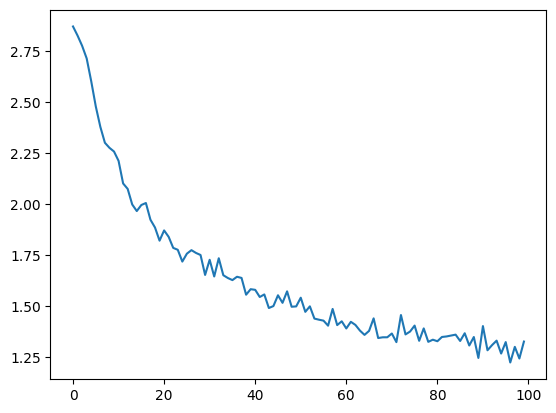

In [48]:
# all_losses를 이용한 손실 도식화
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.plot(all_losses)
plt.show()

## 결과 평가

<ipython-input-51-1bf710441df6>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-51-1bf710441df6>:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


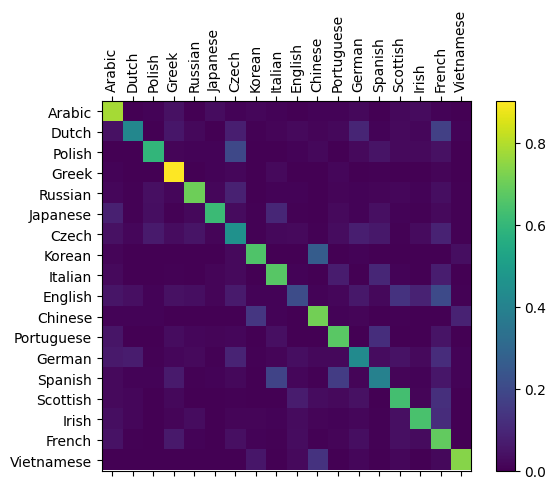

In [51]:
"""
만든 모델이 다른 카테고리에서 얼마나 잘 작동하는지 보기 위해 confusion matrix 생성
    * confusion matrix: 모든 실제 언어(행)가 네트워크에서 어떤 언어(열)로 추측되는지
confusion matrix 계산 위해 evaluate()로 많은 수의 샘플을 네트워크에 실행
"""

# 혼란 행렬 생성
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# 주어진 라인의 출력 반환
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# 예시들 기록
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# 모든 행을 정규화(합계로 나누기)
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# figure 설정
fig = plt.figure()

# 1,1인 space에 첫번째 subplot 생성
ax = fig.add_subplot(111)

# 배열을 matrix로 나타내기 위한 함수
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# 축 설정
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# 모든 tick에서 레이블 지정
# x축과 y축의 주요 눈금 위치를 1부터 10까지 1씩 증가하도록 설정
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [52]:
# 사용자 입력으로 실행
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])


predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.77) Russian
(-0.86) Czech
(-2.70) English

> Jackson
(-0.21) Scottish
(-2.23) English
(-2.97) Russian

> Satoshi
(-0.72) Arabic
(-1.93) Italian
(-2.34) Portuguese
